# Determining ice sheet change using Greenland Ice Mapping Project (GrIMP) tools
---

## GrIMP Overview and Tutorial Goals

![GrIMP header](./images/GrIMP_header.png)

```{note} Learning Objectives
	
1. Access GrIMP velocity products, formatted as cloud optimized GeoTIFF
2. Explore product header info and structure
3. Use interactive subsetting and save tools
4. Use lazy loads to quickly plot imagery and velocity
5. Combine raster and vector data to quickly assess glacier speed and terminus change 
```

This notebook illustrates some of the various tools and capabilities available to access and explore imagery and velocity data products from the Greenland Ice Mapping Project [GrIMP](https://nsidc.org/grimp). Specifically, we will use the functionality of `nisarVel` and `nisarVelSeries` classes for working with GrIMP velocity products.

This notebook will also include examples of how to quickly explore imagery and velocity mosaics, formatted as cloud optimized GeoTIFF (more on that below) to interactively select and download subsets of GrIMP imagery (NSIDC-0723) and velocity (NSIDC-481, 0725, 0727, 0731, 0766) data. For the Sentinel-based velocity mosaics (0725, 0727, 0731), a user can select a box on a map and choose which components are downloaded (vv, vx, vy, ex, ey, dT) and saved to a netCDF file. 

We will explore some of this functionality, read in and plot velocities over an area of interest, quickly run some statistical calculations to visualize how ice flow has changed. We will also combine data with vector data (digitized annual front positions, product 0642), to assess glacier speed and terminus change in tangent.

## Environment setup

Generally, GrIMP notebooks use a set of tools that have been tested with the `environment.yml` in the *binder* folder of the [**GrIMP repository**](https://github.com/fastice/GrIMPTools). Thus, for best results when using GrIMP notebooks in the future and in local instances, create a new conda environment to run this and other other GrIMP notebooks from this repository. After downloading the `environment.yml` file, enter the following commands at the command line to prepare your environment. For today's tutorial in CryoCloud, we do not need to perform these steps.

`conda env create -f binder/environment.yml`

`conda activate greenlandMapping`

`python -m ipykernel install --user --name=greenlandMapping`

`jupyter lab`

See [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for additional information.

The notebooks can be run on a temporary virtual instance (to start click [**binder**](https://mybinder.org/v2/gh/fastice/GrIMPNotebooks/HEAD?urlpath=lab)). See the github [README](https://github.com/fastice/GrIMPNotebooks#readme) for further details.

### Specialty GrIMP product imports

```{note}
In order to use the full functionality of GrIMP notebooks for this tutorial, we will pip install two
two packages with funcitons for reading, subsetting, plotting, and downloading various datasets.
```

In [1]:
%pip install git+https://github.com/fastice/grimpfunc.git@master
%pip install git+https://github.com/fastice/nisardev.git@main

  Cloning https://github.com/fastice/grimpfunc.git (to revision master) to /tmp/pip-req-build-gsypl_mj
  Running command git clone --filter=blob:none --quiet https://github.com/fastice/grimpfunc.git /tmp/pip-req-build-gsypl_mj
  Resolved https://github.com/fastice/grimpfunc.git to commit 42f21acc998bae5cbce342af78252f39b30bc7a5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached panel-0.14.4-py2.py3-none-any.whl (20.8 MB)
  Using cached rio_stac-0.8.1-py3-none-any.whl (10 kB)
  Using cached stackstac-0.5.0-py3-none-any.whl (63 kB)
  Using cached progressbar2-3.55.0-py2.py3-none-any.whl (26 kB)
  Using cached holoviews-1.18.1-py2.py3-none-any.whl (4.3 MB)
  Using cached holoviews-1.17.1-py2.py3-none-any.whl (4.3 MB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
  Using cached python_utils-3.8.1-py2.py3-none-any.whl (27 kB)
  Created wheel for grimpfunc: filename=grimpfunc-0.0.5-py3-

### Common package imports

In [2]:
# Ignore warnings for tutorial
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import geopandas as gpd
#import json
import pyproj
import numpy as np
import earthaccess
import glob
import os
import sys
import re
import matplotlib.pyplot as plt
from IPython.display import Image
import rasterio
from rasterio import plot

import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)
import nisardev as nisar
import grimpfunc as grimp
import panel
panel.extension()
import datetime
from datetime import date, datetime
import xarray as xr
from shapely.geometry import box, Polygon
os.environ['USE_PYGEOS'] = '0'

from IPython.lib.deepreload import reload


%load_ext autoreload
%autoreload 2

In [3]:
# For searching NASA data
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 01/27/2024
Using .netrc file for EDL




### &#x1F4CC; More tutorial guidance:
See our [YouTube](https://www.youtube.com/@GreenlandIceMappingProject) page for more:

In [4]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/0kIcSXkxaxI" \
     frameborder="0" allow="accelerometer" allowfullscreen></iframe>')

```{note}
**To get help and see options for any of the GrIMP or other functions while the cursor is \
positioned inside a method's parentheses, click shift+Tab.**
```

## Overview of COGs and GrIMP product exploratory tool

GrIMP velocity products are stored at NSIDC in cloud-optimized GeoTIFF (COG) format with each component stored as a separate band (e.g., vx, vy, or vv). In this notebook, we focus on the velocity data, but the error and x and y displacement components can be similarly processed.

For reading the data, the products are specified with a single root file name (e.g., for `*filename.vx(vy).othertext.tif*`). For example, the version 3 annual mosaic from December 2017 to November 2018 is specified as `GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v03.0`. For locally stored files, the corresponding path to the data must be provided. For remote data, the https link is required.  In the following example, the `initialSearch()` function populates a gui search window, which allows the search parameters to be altered.

Note, you *may* need to run this cell block twice to initially see the list and total file number repopulate to your selections.

In [5]:
myUrls = grimp.cmrUrls(mode='subsetter')  # Subsetter mode is required for subsetting.
display(myUrls.initialSearch())

Row
    [0] Column(min_width=700)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=700)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method, _pane=DataFrame)
        [1] ParamMethod(method, _pane=Markdown)
        [2] ParamMethod(method, _pane=Markdown)

This cell will pop up a search tool for the GrIMP products, which will run a predefined search for the annual products. While in principle, other products (e.g., six-day to quarterly can be retrieved, the rest of the notebook will need some modifications to accomodate).

### Preload Data and Select Bands
The cells in this section read the cloud-optimized geotiffs (COG) headers and create nisarVelSeries or nisarImageSeries objects for velocity or image data, respectively. The actual data are not downloaded at this stage, but the xarray internal to each object will read the header data of each product so it can efficiently access the data during later downloads. The bands (e.g., vx, vy) can be selected at this stage.

More detail can found on working with these tools in the workingWithGrIMPVelocityData and workingWithGrIMPImageData notebooks. 

```{note}
The  nisar class is used to read, display, velocity maps with a single time stamp. In this example, the `readSpeed=False` (default) forces the speed to be calculated from the individual components rather than read from a file, which is much quicker.

: Here is an example of how to access header information remotely and see the structure and total size of your potential download

:     myVelSeries = nisar.nisarVelSeries() 
      myVelSeries.readSeriesFromTiff(myUrls.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False, useErrors=True, useDT=True)  
      myVelSeries.xr
```

### View example mosaic product from local file
For the purpose of this tutorial, we will read in a file saved locally to the shared directory to visualize an example of the annual velocity mosaic. The cell block below uses a function in the `nisar` package to initialize a nisarVelSeries instance:

In [6]:
myVelSeries = nisar.nisarVelSeries() 
localUrl = '/home/jovyan/shared-public/GeoTIFF/GL_vel_mosaic_Annual_01Dec20_30Nov21_*_v04.0'
myVelSeries.readSeriesFromTiff([localUrl], useDT=False,useErrors=False,readSpeed=True,url=False,useStack=True,overviewLevel=1)  
myVelSeries.xr

<xarray.DataArray 'VelocitySeries' (time: 1, band: 3, y: 3425, x: 1896)>
dask.array<concatenate, shape=(1, 3, 3425, 1896), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -6.587e+05 -6.579e+05 ... 8.567e+05 8.575e+05
  * y            (y) float64 -6.395e+05 -6.403e+05 ... -3.378e+06 -3.379e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2021-06-01
  * band         (band) <U2 'vx' 'vy' 'vv'
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        datetime64[ns] 2020-12-01
    time2        datetime64[ns] 2021-11-30

#### Plot velocity map

 We can use the `displayVelforDate` function by executing: 
 ```
     myVelSeries = nisar.nisarVelSeries.displayVelForDate()
```
This will plot the velocity map for the annual mosaic nearest the user-provided date. Below, we will use mid 2021.   &#x2B07;. 

[########################################] | 100% Completed | 355.92 ms
[########################################] | 100% Completed | 101.71 ms


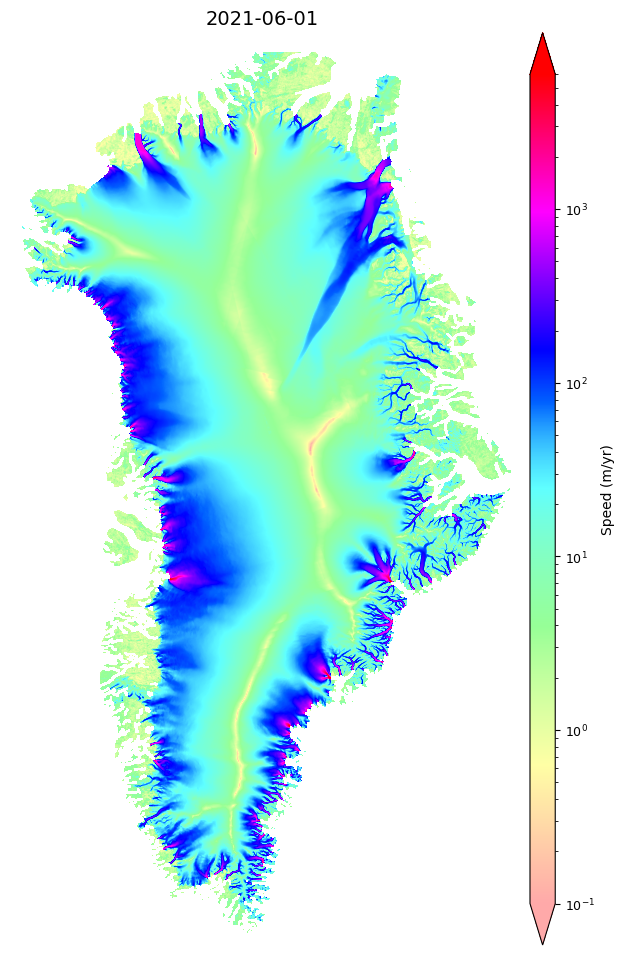

In [7]:
myVelSeries.displayVelForDate('2021-06-01',labelFontSize=10, plotFontSize=9, titleFontSize=14, 
                              vmin=0, vmax=6000,scale='log',colorBarPad=0.15,units='km', axisOff=True)

## &#128208; Spatial subsetting routines 
&#x1F6A8;**These files can be large!**

Below are functions that allow you to quickly *subset the data by spatial bounds*, including the functions you can use to interactively select an ROI when exploring datasets remotely

### Method 1: Interactive ROI Selection
Run the next the tool below to select the bounding box (or modify a manually selected box), which will display a SAR image map. Depending on network speed, it could take a few seconds to a minute to load the basemap. Use the box tool in the plot menu to select a region of interest. 

```{admonition} Interactive ROI selection
:
:     if 'boxPicker' not in locals(): # Only create if not defined above
          boxPicker = grimp.boxPicker()
      boxPicker.plotMap(show=(not myUrls.checkIDs(['NSIDC-0481']) and not myUrls.checkIDs(['NSIDC-0646'])))
```

### Method 2: Manual Selection
The coordinates for a bounding box can be manually entered by modifying the cell below with the desired values. Even if not using interactive selection, running that step displays the manually selected box coordinates on a radar map of Greenland. Note by default, coordinates are rounded to the nearest kilometer. We will use numpy to define a specific x and y bounds of our ROI for the tutorial today.

In [8]:
values = np.around([-472889, -2540695,-453487, -2523127])
xyBounds = dict(zip(['minx', 'miny', 'maxx', 'maxy'], values))
xyBounds

myVelSeries.subSetVel(xyBounds)
myVelSeries.subset

<xarray.DataArray 'VelocitySeries' (time: 1, band: 3, y: 22, x: 25)>
dask.array<getitem, shape=(1, 3, 22, 25), dtype=float32, chunksize=(1, 1, 22, 25), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -4.731e+05 -4.723e+05 ... -4.547e+05 -4.539e+05
  * y            (y) float64 -2.524e+06 -2.524e+06 ... -2.54e+06 -2.54e+06
  * time         (time) datetime64[ns] 2021-06-01
  * band         (band) <U2 'vx' 'vy' 'vv'
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        datetime64[ns] 2020-12-01
    time2        datetime64[ns] 2021-11-30
    spatial_ref  int64 0

The data in the above example map are stored as an Xarray, velMap.subset, here representing data clipped spatially by `xyBounds` at one time slice. The full time series of Greenland-wide mosiacs can reach sizes of > 8GB and may take awhile to download! Because of the lazy open mentioned above, the data have not been downloaded or read from the disk yet. Before applying the final subset, its useful to examine the size of the full data (virtual) array. If the loadDataArray step was sucessful, running the cell above will provide details on the size and organization of the full xarray (prior to any download).

```{admonition} Optionally download subset as netcdf file
The downloaded subset can be saved in a netcdf and reloaded for to velSeries instance for later   analysis.   Note if the data have been subsetted, ONLY the subset will be saved - so it is not a bad idea to check out the dimensions, variable names, and total size of the subset data one last time prior to downloading.

: Apply spatial subset and evaluate subsetted data size and structure          
:     myVelSeries.subSetVel(xyBounds)
      myVelSeries.subset

: If wishing to save your subset as a netcdf, follow the examples below:
:     subsetFile = 'steenstrupGlacier_annVel.nc'
      myVelSeries.loadRemote()
      myVelSeries.toNetCDF(subsetFile)
      
```


### Use predownloaded subset for plotting
Now, let's initialize another nisarVlSeries instance, and reload the previously downloaded data file 
(saved as netcdf) to that instance. &#x2B07;

In [9]:
myVelReload = nisar.nisarVelSeries() 
myVelReload.readSeriesFromNetCDF('./res/steenstrupGlacier_annVel.nc')
myVelReload.loadRemote()
myVelReload.xr #confirm dimensions of read-in subsetted velocities

### &#128397; Plot the annual velocity maps for Steenstrup Glacier (the glacier within our example spatial subset). 

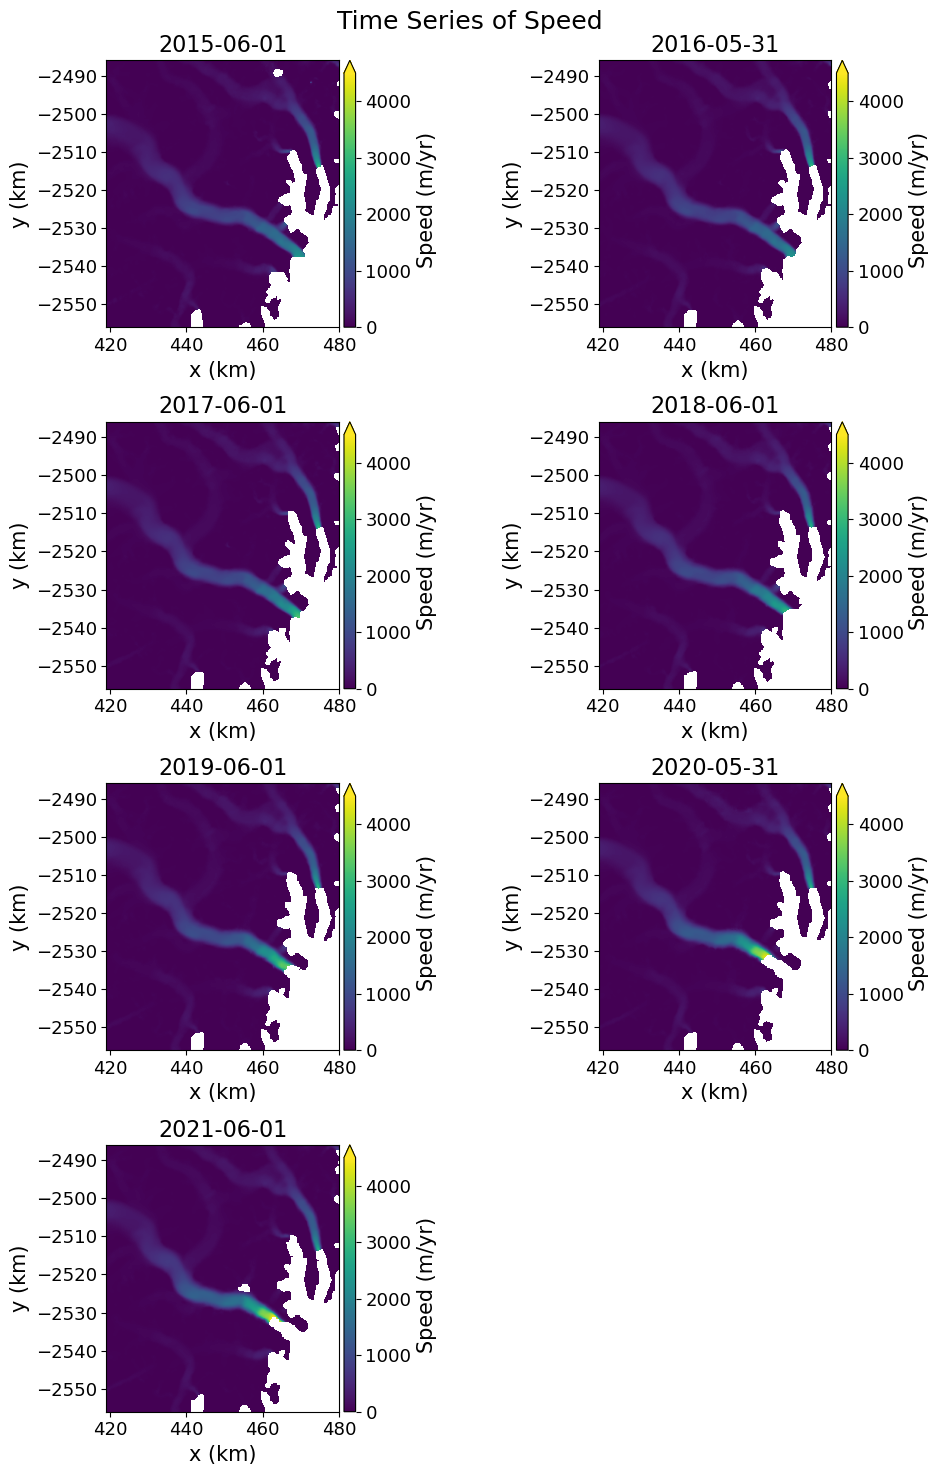

In [98]:
fig, axes = plt.subplots(4, 2,figsize=(10,15))

for ax, date in zip(axes.flatten(), myVelReload.time): 
    myVelReload.displayVelForDate(date=date, ax=ax,autoScale=False,vmin=0,vmax=4500,units='km')
axes[-1, -1].axis('off'); #remove any empty axes if odd number of years
fig.suptitle('Time Series of Speed', fontsize=18)
fig.tight_layout()

### &#x1F4CA; Quickly plot velocity anomalies
computes [velocity at t_i - mean] of all timesteps in data series

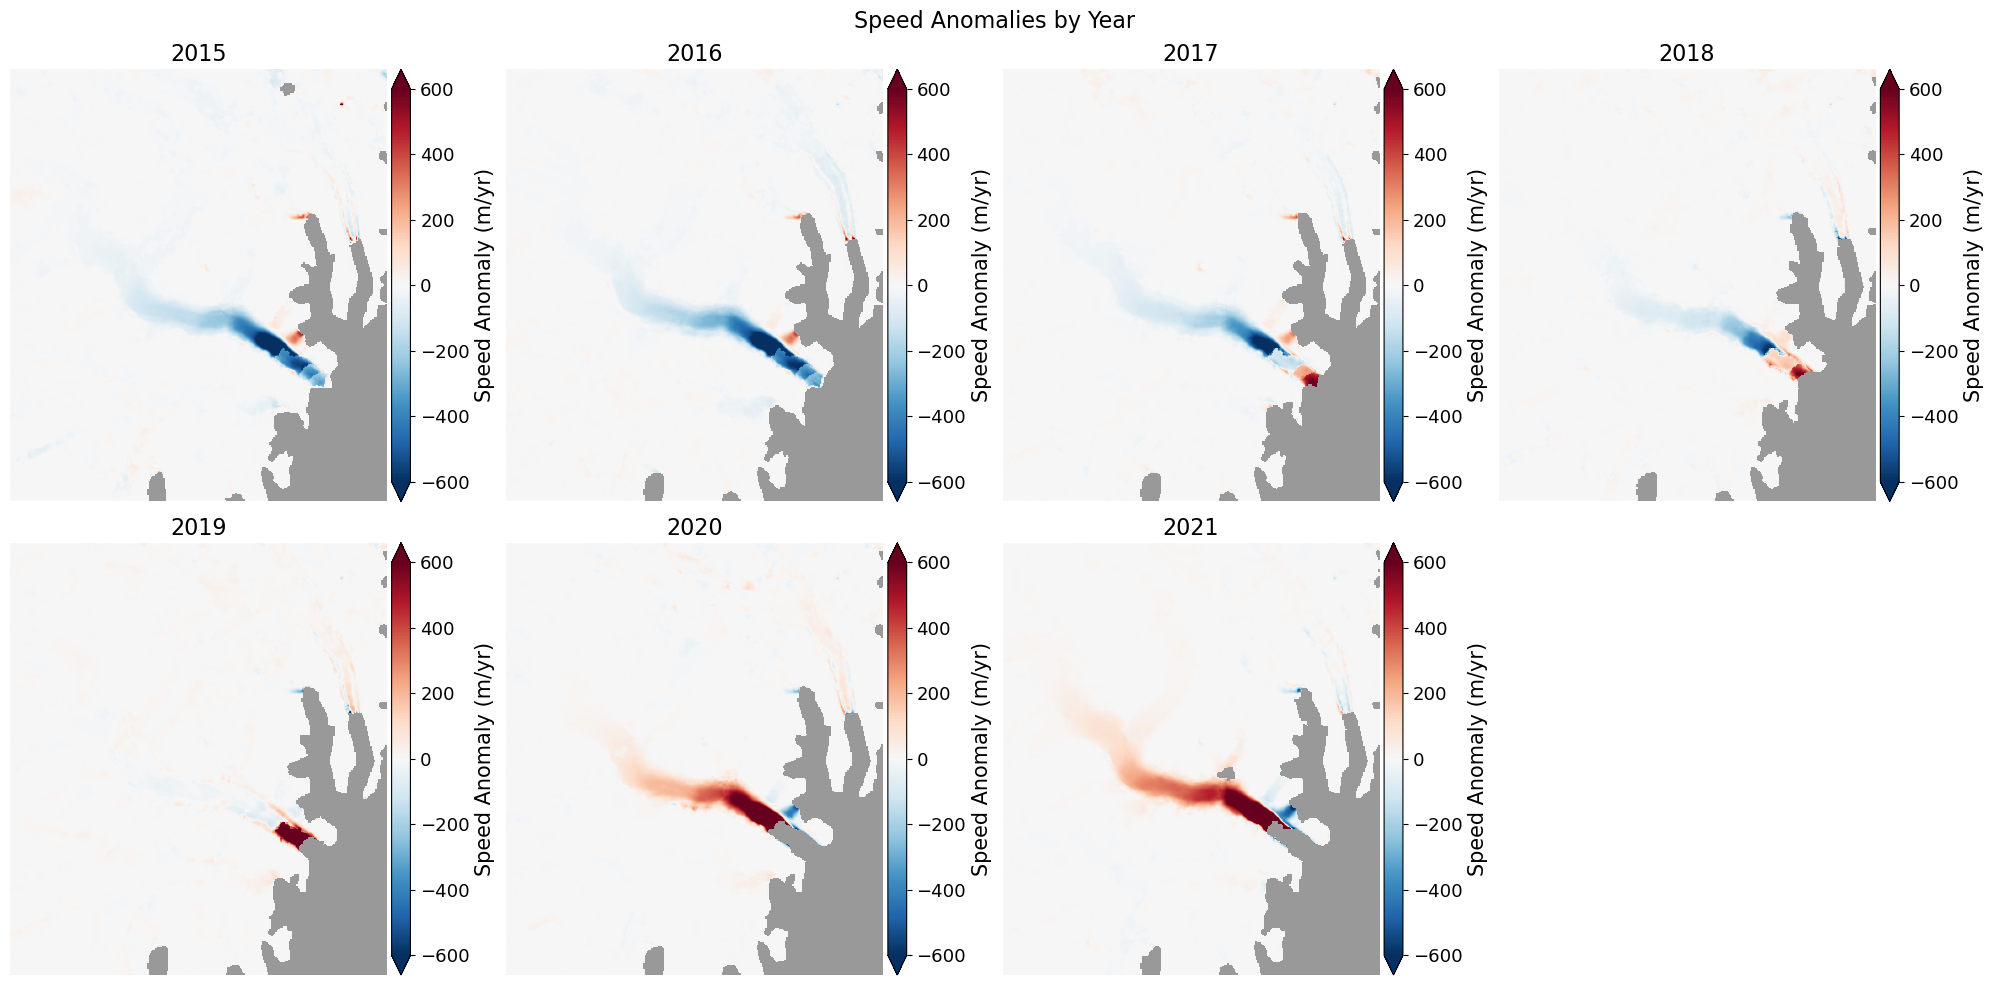

In [94]:
velAnomaly = myVelReload.anomaly()

# Plot the anomaly for each year
fig, axes = plt.subplots(2, 4, figsize=(20,10))
for date, ax in zip(velAnomaly.time, axes.flatten()):
    velAnomaly.displayVelForDate(date, ax=ax, units='m', vmin=-600, vmax=600, autoScale=False, axisOff=True,
                                 title=date.strftime("%Y"),cmap='RdBu_r', colorBarLabel='Speed Anomaly (m/yr)', 
                                 extend='both',backgroundColor=(0.6, 0.6, 0.6))
axes[-1, -1].axis('off'); # kill axis with no plot
fig.suptitle('Speed Anomalies by Year', fontsize=16)
fig.tight_layout()

### &#x1F4C8; Explore multiyear trends with Quick tool
Use the interactive inspection tool in the cell block below to quickly visualize multiyear trends &#x2B07;

In [95]:
myVelReload.inspect()

HoloViews(Layout)

## &#128205; Combine GrIMP raster and vector data
Let's read in digitized annual glacier terminus traces within this ROI. The `compiled.shp` file is an aggregate of 2009-2021 annual terminus data from GrIMP product [**NSIDC-0642**](https://nsidc.org/data/nsidc-0642/versions/2). Run the cell block below to quickly view the Greenland-wide dataset.

<Axes: >

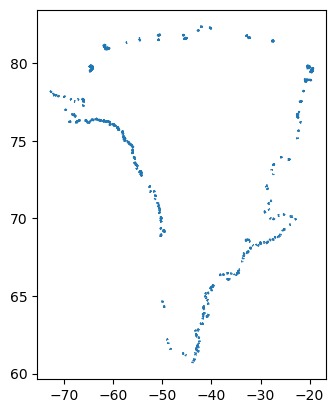

In [11]:
fronts = gpd.read_file("/home/jovyan/GrIMP/shpfiles/compiled.shp")
%matplotlib inline
fronts.plot()

In [96]:
# define a polygone based on the xy extents of our reloaded velocity data
vv = myVelReload.subset[:,2,:,:] #select 'vv' band
poly = Polygon([(min(vv.x), min(vv.y)), (min(vv.x),max(vv.y)), (max(vv.x), max(vv.y)), (max(vv.x),min(vv.y))])
clippoly = gpd.GeoDataFrame([1], geometry = [poly], crs = 'EPSG:3413')

# we will reproject these coordinates to lat/lon to match the terminus data and apply as a 
# polygon for spatial subsetting
clippoly = clippoly.to_crs("epsg:4326")
clippedfronts = gpd.clip(fronts,clippoly)

# Reproject back to native coordinate system of velocity data for plotting
clippedfronts = clippedfronts.to_crs("EPSG:3413")


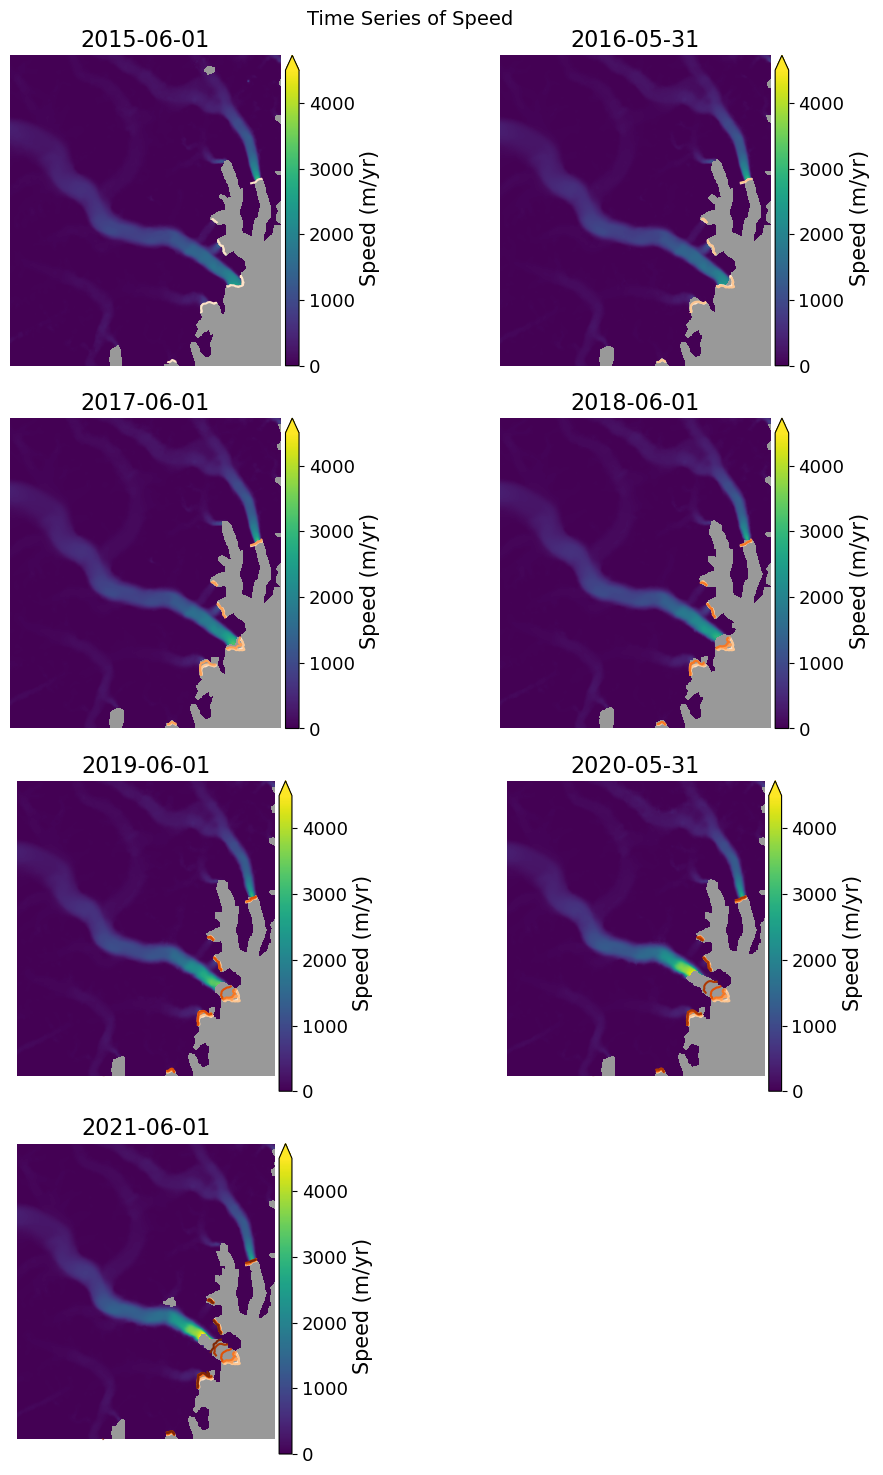

In [97]:
Or = plt.colormaps['Oranges'].resampled(8)

fig, axes = plt.subplots(4, 2,figsize=(10,15))

#define first year of time series
Yr1 = myVelReload.time[0].year

for ax, date in zip(axes.flatten(), myVelReload.time): 
    # Now plot. NOTE:if declaring a min and max velocity, be sure to also set autoScale = False.
    myVelReload.displayVelForDate(date=date, ax=ax, axisOff=True, autoScale=False,vmin=0,vmax=4500,backgroundColor=(0.6,0.6,0.6))
    yr = datetime.date(date).year
    pd.to_datetime(clippedfronts["SourceDate"]).dt.year
    clipYr = clippedfronts.loc[pd.to_datetime(clippedfronts["SourceDate"]).dt.year <= yr]
    
    #sort shapefile features by date
    SortedTerm = clipYr.sort_values(by='SourceDate',ascending=True)

    #plot front positions up through subplot year through time
    for i in range(Yr1,yr+1):
        SortedTerm.loc[pd.to_datetime(SortedTerm["SourceDate"]).dt.year == i].plot(
            ax=ax,column = 'SourceDate',color=Or(i-(Yr1-1)),zorder = i-(Yr1-2))
        

axes[-1, -1].axis('off'); #remove any empty axes if odd number of years
fig.suptitle('Time Series of Speed', fontsize=14)
fig.tight_layout()
plt.show()